# 📊 Round Robin Benchmark Analysis

This notebook loads the latest benchmark results from:

`src/ai/statistics/round_robin_results/*.csv`

and computes winrates, matchup charts, damage statistics, and NEAT-style metrics.

In [22]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Notebook working directory
CWD = Path().resolve()

# Walk upward until we find the project root (folder containing `src/`)
while CWD != CWD.root and not (CWD / "src").exists():
    CWD = CWD.parent

PROJECT_ROOT = CWD
print("Detected project root:", PROJECT_ROOT)

RESULTS_DIR = PROJECT_ROOT / "src/ai/statistics/round_robin_results"
print("Using results dir:", RESULTS_DIR)

csv_files = sorted(RESULTS_DIR.glob("round_robin_*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {RESULTS_DIR}")

latest_csv = csv_files[-1]
print("📄 Loading:", latest_csv)

df = pd.read_csv(latest_csv)
df.head()

Detected project root: /home/cillard/projects/Game
Using results dir: /home/cillard/projects/Game/src/ai/statistics/round_robin_results
📄 Loading: /home/cillard/projects/Game/src/ai/statistics/round_robin_results/round_robin_20251208_203656.csv


,agentA,agentB,winner,turns,initial_unit_count_team1,initial_unit_count_team2,alive1,alive2,max_hp_team1,max_hp_team2,hp1,hp2
0,NEATAgent,MCTSAgent,1,19,4,4,3.0,0.1,325,355,102,1
1,MCTSAgent,NEATAgent,2,20,4,4,0.1,4.0,435,320,1,126


## 🧮 Winrate Summary

In [23]:
agents = sorted(set(df["agentA"]) | set(df["agentB"]))

win_stats = {a: {"wins": 0, "games": 0} for a in agents}

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]
    win_stats[A]["games"] += 1
    win_stats[B]["games"] += 1
    if winner == 1:
        win_stats[A]["wins"] += 1
    elif winner == 2:
        win_stats[B]["wins"] += 1

summary = pd.DataFrame(
    [
        {
            "agent": agent,
            "winrate": win_stats[agent]["wins"] / win_stats[agent]["games"],
            "games": win_stats[agent]["games"],
        }
        for agent in agents
    ]
).set_index("agent")

summary

,winrate,games
agent,,
MCTSAgent,0.0,2
NEATAgent,1.0,2


## 🔥 Head-to-Head Winrate Matrix

In [24]:
matrix = pd.DataFrame(0.0, index=agents, columns=agents)

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]
    if winner == 1:
        matrix.loc[A, B] += 1
    elif winner == 2:
        matrix.loc[B, A] += 1

games_matrix = df.groupby(["agentA", "agentB"]).size().unstack(fill_value=0)

winrate_matrix = matrix.div(games_matrix + games_matrix.T, fill_value=0)
winrate_matrix

,MCTSAgent,NEATAgent
MCTSAgent,NaN,0.0
NEATAgent,1.0,NaN


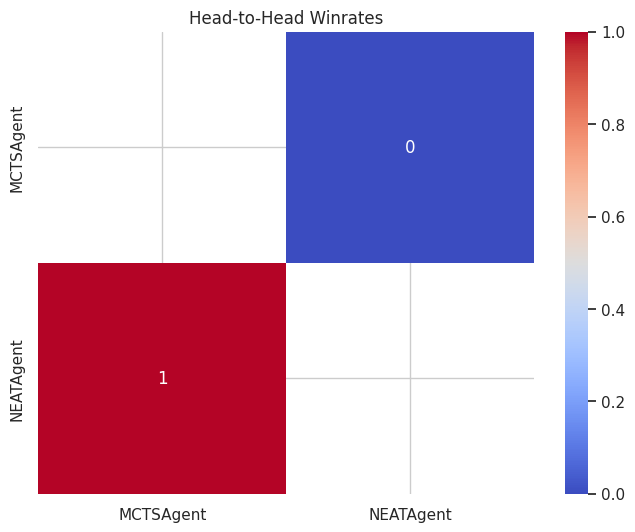

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(winrate_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Head-to-Head Winrates")
plt.show()

## ❤️ HP Advantage vs Win

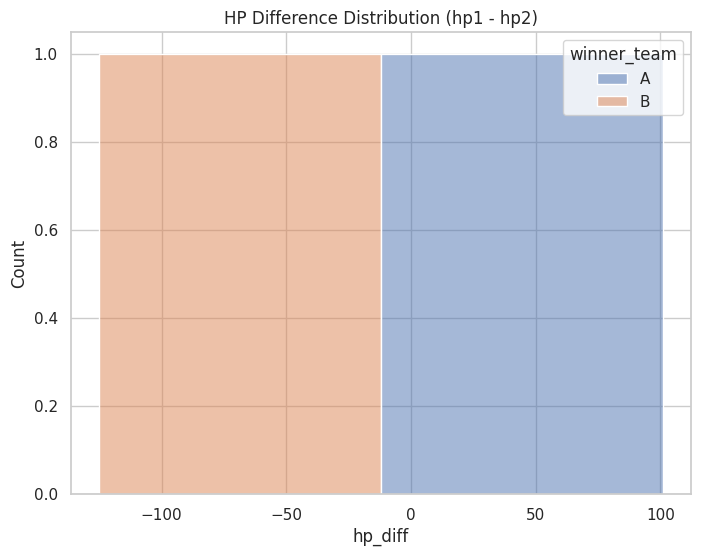

In [26]:
df["hp_diff"] = df["hp1"] - df["hp2"]
df["winner_team"] = df["winner"].map({1: "A", 2: "B"})

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="hp_diff", hue="winner_team", kde=True)
plt.title("HP Difference Distribution (hp1 - hp2)")
plt.show()

## 🛡 Survival Analysis (Alive Units)

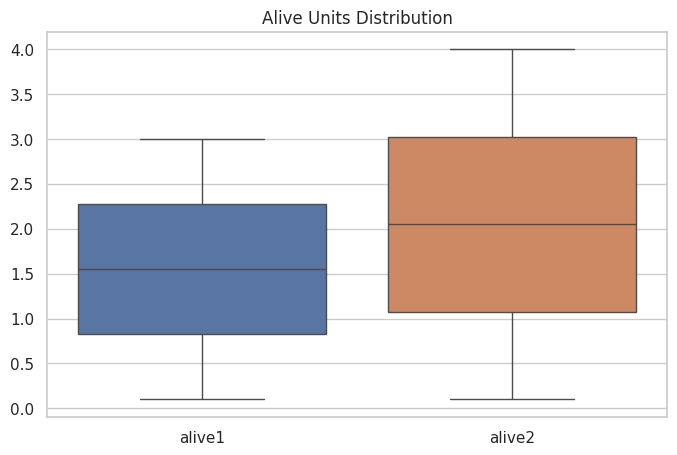

In [27]:
alive_df = df[["agentA", "agentB", "alive1", "alive2"]]
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[["alive1", "alive2"]])
plt.title("Alive Units Distribution")
plt.show()